## **Regional Classifier Development**<br>
This notebook outlines the steps involved in building a regional classifier using a transfer learning method. The pre-trained model used in this notebook is downloaded from the IFCB UTOPIA (https://github.com/ifcb-utopia/ml-workflow?tab=readme-ov-file)

<small>*Ali Chase, & Valentina Staneva. (2025). ifcb-utopia/ml-workflow: ifcbUTOPIA CNN for Classification (v0.1-alpha). Zenodo. https://doi.org/10.5281/zenodo.15547825*</small>

The notebook includes:<br>

**STEP-1**: Data Loading and Label Encoding

**STEP-2**: Dataset Organization for Training

**STEP-3**: Switch Colab to GPU

**STEP-4**: Preparing Labels and Images

**STEP-5**: Load and Train the Model

**STEP-6**: Evaluate the Model

**FOR GOOGLE COLAB ONLY**<br>
This notebook is executed in Google Colab, which provides free access to GPU resources for training deep learning models. Since training on image data requires significant computational power, leveraging Google Colab’s GPU helps accelerate the process and improves efficiency. By utilizing Colab’s GPU, we can perform resource-intensive tasks, like training large models on image datasets, in a faster and more efficient manner compared to using a local CPU.The below cell is for mounting your Google Drive to Colab, where your datasets and files should be stored for easy access during training.<br>

This notebook can be also follow by Google Colab: https://colab.research.google.com/drive/1rEZDNOt2a-5x5gh4faUsbOs-vHCaAlzD?usp=sharing 



In [ ]:
# Sets the home directory as gdrive, the images and labels should be locate in your google drive.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
import cv2
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from keras.utils import to_categorical

**Versions of the necessary packages**:<br>
pandas version: 2.2.2<br>
matplotlib version: 3.10.0<br>
opencv version: 4.11.0<br>
numpy version: 2.0.2<br>
tensorflow version: 2.18.0<br>
scikit-learn version: 1.6.1<br>
keras version: 3.8.0<br>


## **Data Loading and Label Encoding**<br>

**1-Load the data**: The 3D dataset and corresponding labels are loaded into the environment for further processing.

**2- Analyze class distribution**: The class distribution of the labels is examined to understand the balance between different classes.

**3- Preprocess the data**: The dataset is reshaped to 4D and normalized to a range of [0, 1].

 **4-Identify augmented images**: An "is_augmented" column is added to the labels to identify which images are augmented based on the filename pattern.

**5-Encode the labels**: The labels are transformed using LabelEncoder and then converted to one-hot encoded format for multi-class classification.



**Load the data**<br>
The below cell loads the preprocessed 3D dataset (dataset_3d) and the corresponding labels (label_df) from saved files in google drive. The dataset is a 3D array where each element represents an image, and the labels are stored in a CSV file with additional information, such as the folder name and image path. The shapes of the dataset and labels are printed for confirmation, ensuring that the data has been correctly loaded.

In [ ]:
import numpy as np
import pandas as pd

# ✅ Load preprocessed 3D dataset (grayscale, padded)
dataset_3d = np.load('/content/gdrive/MyDrive/practice_models/EcoFOCI_v2/EcoFOCI_v2_trimmed_3d.npy')

# ✅ Load the corresponding labels
label_df = pd.read_csv('/content/gdrive/MyDrive/practice_models/EcoFOCI_v2/Copy of EcoFOCI_v5_train_trimmed.csv')

# ✅ Check
print("✅ dataset_3d shape:", dataset_3d.shape)
print("✅ label_df shape:", label_df.shape)
print(label_df[['Folder_Name', 'Image_Path']].head())


✅ dataset_3d shape: (25431, 128, 128)
✅ label_df shape: (25431, 16)
  Folder_Name                                         Image_Path
0   Elongated  /content/gdrive/MyDrive/practice_folder/Traini...
1   Elongated  /content/gdrive/MyDrive/practice_folder/Traini...
2   Elongated  /content/gdrive/MyDrive/practice_folder/Traini...
3   Elongated  /content/gdrive/MyDrive/practice_folder/Traini...
4   Elongated  /content/gdrive/MyDrive/practice_folder/Traini...


**Analyze Class Distribution**<br>
This step calculates the distribution of the labels in the Folder_Name column of the label_df DataFrame. It shows how many samples belong to each class by using value_counts(), and optionally sorts the counts alphabetically using sort_index(). This helps to understand the balance of classes and whether any class might be underrepresented or overrepresented.

In [ ]:
import pandas as pd

# Assuming your dataframe is already loaded as label_df
group_counts = label_df['Folder_Name'].value_counts()

# Display the result
print(group_counts)

# If you want to sort alphabetically instead of by count:
group_counts_sorted = group_counts.sort_index()
print(group_counts_sorted)


Folder_Name
Thalassiosira       1848
Chaetoceros         1695
Detritus            1615
Elongated           1568
Nanoflagellate      1350
Dinoflagellate      1156
Cryptophyte         1050
Ciliate             1049
Coccoliths          1047
Pennate             1028
Dictyocha           1009
Corethron           1009
Coscinodiscus       1005
Euglena             1002
Thalassionema       1000
Pseudonitzschia     1000
Ditylum             1000
Cylindrotheca       1000
Alexandrium         1000
Tintinnid           1000
Asterionellopsis    1000
Phaeocystis         1000
Name: count, dtype: int64
Folder_Name
Alexandrium         1000
Asterionellopsis    1000
Chaetoceros         1695
Ciliate             1049
Coccoliths          1047
Corethron           1009
Coscinodiscus       1005
Cryptophyte         1050
Cylindrotheca       1000
Detritus            1615
Dictyocha           1009
Dinoflagellate      1156
Ditylum             1000
Elongated           1568
Euglena             1002
Nanoflagellate      1350


**Preprocess the data**<br>
This step reshapes the 3D dataset into 4D by adding a channel dimension (since the images are grayscale, the channel is 1), making the shape compatible with the neural network input. Additionally, the pixel values are normalized to the range [0, 1] by dividing by 255, ensuring the model works with scaled values. The shape, data type, and pixel range are printed to verify the changes.

In [ ]:
# ✅ Reshape from 3D to 4D by adding channel dimension
dataset_4d = np.expand_dims(dataset_3d, axis=-1)  # Shape: (N, 128, 128, 1)

# ✅ Normalize to range [0, 1]
dataset_4d = dataset_4d.astype('float32') / 255.0

# ✅ Confirm
print("✅ dataset_4d shape:", dataset_4d.shape)
print("✅ dtype:", dataset_4d.dtype)
print("✅ pixel range: min =", dataset_4d.min(), ", max =", dataset_4d.max())


✅ dataset_4d shape: (25431, 128, 128, 1)
✅ dtype: float32
✅ pixel range: min = 0.0 , max = 1.0


**Identify augmented Images**<br>
This step adds a new column is_augmented to the label DataFrame, which identifies whether an image is augmented by checking the file path for the substring "aug_". When saving the augmented data, this pattern is used in the filenames (e.g., images with "aug_" in the name are considered augmented). This allows the dataset to distinguish between original and augmented images. The counts of augmented vs. non-augmented images are printed, and a few samples are displayed for verification.

In [ ]:
# ✅ Add 'is_augmented' column using filename pattern
label["is_augmented"] = label["Image_Path"].str.contains("aug_", case=False, na=False)

# ✅ Confirm the counts
print("✅ Augmented Image Counts:")
print(label["is_augmented"].value_counts())

# Optional: check a few samples
print("\n✅ Sample:")
print(label[["Image_Path", "is_augmented"]].sample(5))


✅ Augmented Image Counts:
is_augmented
False    14917
True     10514
Name: count, dtype: int64

✅ Sample:
                                              Image_Path  is_augmented
7780   /content/gdrive/MyDrive/practice_folder/Traini...          True
22956  /content/gdrive/MyDrive/practice_folder/test_d...         False
7060   /content/gdrive/MyDrive/practice_folder/Traini...          True
2361   /content/gdrive/MyDrive/practice_folder/Traini...         False
14408  /content/gdrive/MyDrive/practice_folder/five_g...         False


**Encode the Labels**<br>
In the below cell, the LabelEncoder is used to convert the string labels (e.g., 'Class1', 'Class2') into integers (e.g., 0, 1). These integer labels are then converted into one-hot encoded labels using to_categorical(), which is required for multi-class classification tasks. The shape of the one-hot encoded labels is printed, confirming the final format for model training.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# ✅ Extract unique class labels
class_names = sorted(label["Folder_Name"].unique())
num_classes = len(class_names)

# ✅ Fit LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(class_names)

# ✅ Encode to integers, then one-hot
encoded_labels = label_encoder.transform(label["Folder_Name"])
onehot_labels = to_categorical(encoded_labels, num_classes)

# ✅ Confirm shape
print(f"✅ onehot_labels shape: {onehot_labels.shape}")
print(f"✅ Classes ({num_classes}):", class_names)


✅ onehot_labels shape: (25431, 22)
✅ Classes (22): ['Alexandrium', 'Asterionellopsis', 'Chaetoceros', 'Ciliate', 'Coccoliths', 'Corethron', 'Coscinodiscus', 'Cryptophyte', 'Cylindrotheca', 'Detritus', 'Dictyocha', 'Dinoflagellate', 'Ditylum', 'Elongated', 'Euglena', 'Nanoflagellate', 'Pennate', 'Phaeocystis', 'Pseudonitzschia', 'Thalassionema', 'Thalassiosira', 'Tintinnid']


## **Dataset Organization for Training**<br>
**1-Splitting train, validation, and test data**:The augmented images are separated from the original images to ensure that the augmented data is not included in the validation and test sets, as this could lead to inconsistent model evaluations.

**2-Visual check of images and labels**:Random images from the training and validation sets are displayed with their corresponding labels to verify the integrity and quality of the dataset before training the model.

**3-Save the dataset**:The training, validation, and test datasets, along with their labels, are saved as .npy files and human-readable CSV files for easy access and further processing.

 **Splitting train, validation, and test data**<br>
The code first separates the dataset into original data (non-augmented) and augmented data based on the is_augmented column. It then splits the original data into 70% training and 30% temporary data (used for validation and testing) using train_test_split, ensuring that the class distribution is maintained through stratification. The temporary data is further split into 50% validation and 50% test data. After that, the training set is finalized by combining the original training data with the augmented data. The indices for the final training, validation, and test datasets are extracted, and the image arrays and one-hot encoded labels are used to create the datasets. Finally, the shapes of the datasets are printed to confirm that the splits were successful.

In [ ]:
from sklearn.model_selection import train_test_split

# ✅ Separate original and augmented
original_data = label[label["is_augmented"] == False].copy()
augmented_data = label[label["is_augmented"] == True].copy()

# ✅ Step 1: Split original into 70% train, 30% temp (val + test)
train_orig, temp = train_test_split(
    original_data,
    test_size=0.30,
    stratify=original_data["Folder_Name"],
    random_state=42
)

# ✅ Step 2: Split temp into 15% val, 15% test
val_orig, test_orig = train_test_split(
    temp,
    test_size=0.50,
    stratify=temp["Folder_Name"],
    random_state=42
)

# ✅ Step 3: Final train = original + augmented
train_final = pd.concat([train_orig, augmented_data], ignore_index=True)

# ✅ Step 4: Extract indices
train_indices = train_final.index.tolist()
val_indices = val_orig.index.tolist()
test_indices = test_orig.index.tolist()

# ✅ Step 5: Create datasets from image array and encoded labels
X_train = dataset_4d[train_indices]
y_train = onehot_labels[train_indices]

X_val = dataset_4d[val_indices]
y_val = onehot_labels[val_indices]

X_test = dataset_4d[test_indices]
y_test = onehot_labels[test_indices]

# ✅ Confirm
print(f"✅ X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"✅ X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"✅ X_test:  {X_test.shape}, y_test:  {y_test.shape}")


✅ X_train: (20955, 128, 128, 1), y_train: (20955, 22)
✅ X_val:   (2238, 128, 128, 1), y_val:   (2238, 22)
✅ X_test:  (2238, 128, 128, 1), y_test:  (2238, 22)


 **Plotting the Train and Validation images with Labels to check if it is correct.**<br>
 The below code defines a function plot_random_images that randomly selects n images from the dataset and displays them along with their corresponding labels. It uses random.sample() to pick random indices from the image array, then extracts and displays the images with their predicted class labels. The label_encoder.inverse_transform() function is used to map the class index back to the label name. The images are displayed in a grid, and the plot title reflects whether the images are from the training set or validation set. This function is called twice: once for the training images and once for the validation images, allowing for a quick visual check of the dataset.

<ipython-input-25-cd8f2fe744ac>:19: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


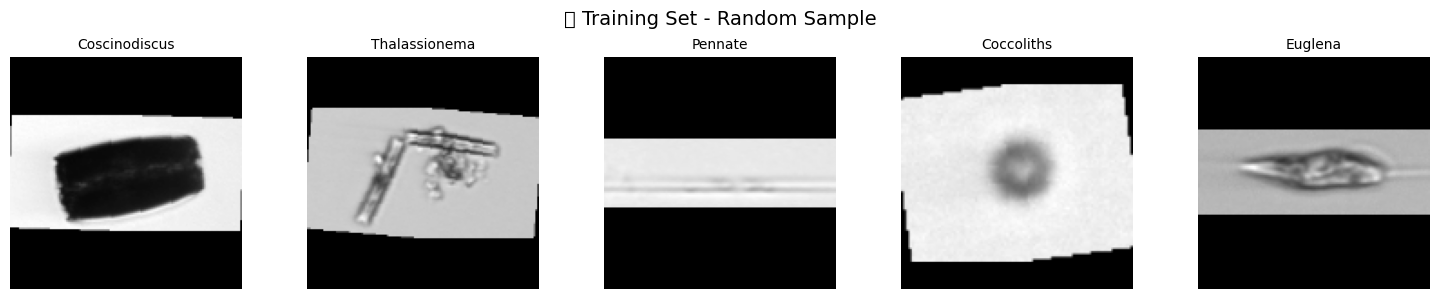

<ipython-input-25-cd8f2fe744ac>:19: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


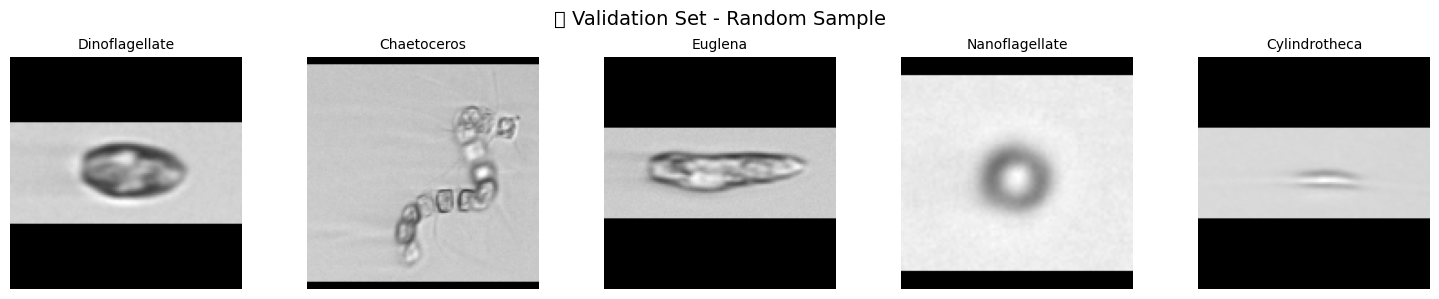

In [ ]:
import matplotlib.pyplot as plt
import random

def plot_random_images(X, y, title="Dataset", n=5):
    indices = random.sample(range(len(X)), n)
    plt.figure(figsize=(15, 3))

    for i, idx in enumerate(indices):
        image = X[idx].squeeze()  # (128,128,1) → (128,128)
        label_index = np.argmax(y[idx])
        label = label_encoder.inverse_transform([label_index])[0]

        plt.subplot(1, n, i + 1)
        plt.imshow(image, cmap="gray")
        plt.title(f"{label}", fontsize=10)
        plt.axis("off")

    plt.suptitle(f"🔍 {title} - Random Sample", fontsize=14)
    plt.tight_layout()
    plt.show()

# ✅ Plot training images
plot_random_images(X_train, y_train, title="Training Set")

# ✅ Plot validation images
plot_random_images(X_val, y_val, title="Validation Set")


 **Save the datasets**<br>
 This code saves the training, validation, and test datasets (images and labels) to the specified output directory using np.save(). It first ensures the output directory exists by using os.makedirs(save_dir, exist_ok=True). Then, it saves the image arrays (X_train, X_val, X_test) and their corresponding one-hot encoded labels (y_train, y_val, y_test) as .npy files. Finally, it prints a confirmation message showing the directory where the datasets were saved.

In [ ]:
#Save images
import os

# ✅ Output directory
save_dir = "/content/gdrive/MyDrive/practice_models/EcoFOCI_v2/splits"
os.makedirs(save_dir, exist_ok=True)

# ✅ Save images
np.save(os.path.join(save_dir, "X_train.npy"), X_train)
np.save(os.path.join(save_dir, "X_val.npy"), X_val)
np.save(os.path.join(save_dir, "X_test.npy"), X_test)

# ✅ Save labels
np.save(os.path.join(save_dir, "y_train.npy"), y_train)
np.save(os.path.join(save_dir, "y_val.npy"), y_val)
np.save(os.path.join(save_dir, "y_test.npy"), y_test)

print("✅ Saved all training, validation, and test splits to:")
print(save_dir)


✅ Saved all training, validation, and test splits to:
/content/gdrive/MyDrive/practice_models/EcoFOCI_v2/splits


**Additional**:<br>
The below code saves the labels for the training, validation, and test sets as human-readable CSV files. It first ensures the output directory exists by using os.makedirs(output_csv_dir, exist_ok=True). Then, it saves the train_labels, val_labels, and test_labels DataFrames as CSV files in the specified directory using to_csv(). Finally, it prints a confirmation message with the location where the label CSV files have been saved.

In [ ]:
#Save labels as csv
# Create output folder if needed
output_csv_dir = "/content/gdrive/MyDrive/practice_models/EcoFOCI_v2/splits"
os.makedirs(output_csv_dir, exist_ok=True)

# Save human-readable CSVs
train_final.to_csv(os.path.join(output_csv_dir, "train_labels.csv"), index=False)
val_orig.to_csv(os.path.join(output_csv_dir, "val_labels.csv"), index=False)
test_orig.to_csv(os.path.join(output_csv_dir, "test_labels.csv"), index=False)

print("✅ Saved label CSVs to:", output_csv_dir)


✅ Saved label CSVs to: /content/gdrive/MyDrive/practice_models/EcoFOCI_v2/splits


## **Switch Google Colab to GPU**<br>
After switching to GPU, the Colab notebook refreshes the memory, requiring the reloading of the training,validation, and test datasets.


**Load the train, validation, and test datasets**<br>
The below cell loads the training, validation, and test datasets, including the images and one-hot encoded labels, from the specified directory (split_dir). The np.load function is used to load the saved .npy files for the images (X_train, X_val, X_test) and their corresponding labels (y_train, y_val, y_test). The print statements confirm the shapes of the datasets to ensure that the data is loaded correctly.

In [ ]:
import numpy as np

# ✅ Base path to your saved splits
split_dir = "/content/gdrive/MyDrive/practice_models/EcoFOCI_v2/splits"

# ✅ Load images
X_train = np.load(f"{split_dir}/X_train.npy")
X_val   = np.load(f"{split_dir}/X_val.npy")
X_test  = np.load(f"{split_dir}/X_test.npy")

# ✅ Load one-hot encoded labels
y_train = np.load(f"{split_dir}/y_train.npy")
y_val   = np.load(f"{split_dir}/y_val.npy")
y_test  = np.load(f"{split_dir}/y_test.npy")

# ✅ Confirm
print(f"✅ X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"✅ X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"✅ X_test:  {X_test.shape}, y_test:  {y_test.shape}")


✅ X_train: (20955, 128, 128, 1), y_train: (20955, 22)
✅ X_val:   (2238, 128, 128, 1), y_val:   (2238, 22)
✅ X_test:  (2238, 128, 128, 1), y_test:  (2238, 22)


**Inspecting the image and label data**:<br>
Teh below cell prints the dimensions and data type of the image and label arrays to ensure the data is loaded properly. It displays:

Shape: The dimensions of the image and label arrays (e.g., number of samples, image size, and number of classes).

Data Type: The type of the image data (e.g., float32, int64).

Range: The minimum and maximum values of the image data, which can help confirm that the images are properly scaled (e.g., 0 to 1 for normalized data).

In [ ]:
print("✅ Image shape:", X_train.shape)
print("✅ Label shape:", y_train.shape)
print("✅ Image dtype:", X_train.dtype, " | range:", X_train.min(), "-", X_train.max())


✅ Image shape: (20955, 128, 128, 1)
✅ Label shape: (20955, 22)
✅ Image dtype: float32  | range: 0.0 - 1.0


## **Preparing the Labels and Images**<br>

**1-Load the labels**: Count the number of samples per class and display the class distribution in a DataFrame.<br>

**2-Rebuild the Label Encoder**: Extract unique class names, sort them, and train the LabelEncoder to map classes to numeric labels. Save the encoder for later use.<br>

**3-Visualize the Images and Labels**: Define a function to randomly select and display n images from the training set with their corresponding labels, ensuring that the data is correctly labeled and visualize.




**Load the Labels-1**

In [ ]:
#LOAD the LABELS
import pandas as pd

# ✅ Adjust path if needed
label = pd.read_csv("/content/gdrive/MyDrive/practice_models/EcoFOCI_v2/splits/train_labels.csv")

# ✅ Confirm
print("✅ Label CSV Loaded:", label.shape)
print(label[["Folder_Name", "Image_Path"]].sample(5))


✅ Label CSV Loaded: (20955, 17)
       Folder_Name                                         Image_Path
3340       Ciliate  /content/gdrive/MyDrive/practice_folder/Traini...
10157    Elongated  /content/gdrive/MyDrive/practice_folder/Traini...
18703    Dictyocha  /content/gdrive/MyDrive/practice_folder/Traini...
2071     Corethron  /content/gdrive/MyDrive/practice_folder/Traini...
20771  Phaeocystis  /content/gdrive/MyDrive/practice_folder/Traini...


**Load the Labels-2**<br>
Belove cell counts the number of samples in each class within the Folder_Name column of the label DataFrame. It then sorts the classes by count in descending order and displays the results in a DataFrame with columns labeled "Class" and "Count".

In [ ]:
# Count samples per class
class_counts = label["Folder_Name"].value_counts().sort_values(ascending=False)

# Display as DataFrame
class_distribution_df = class_counts.reset_index()
class_distribution_df.columns = ["Class", "Count"]

print(class_distribution_df)


               Class  Count
0      Thalassiosira   1293
1     Nanoflagellate   1231
2        Chaetoceros   1186
3           Detritus   1130
4          Elongated   1098
5          Tintinnid    995
6      Thalassionema    992
7        Phaeocystis    981
8   Asterionellopsis    981
9          Dictyocha    961
10     Coscinodiscus    952
11        Coccoliths    950
12     Cylindrotheca    940
13           Ditylum    936
14       Alexandrium    923
15   Pseudonitzschia    827
16         Corethron    821
17    Dinoflagellate    809
18           Pennate    779
19       Cryptophyte    735
20           Ciliate    734
21           Euglena    701


**Rebuild the Encoder-1**<br>
Below code rebuilds the LabelEncoder by first extracting and sorting the unique class names from the Folder_Name column. The encoder is then trained with these class names to map them to numeric values, and the encoded class labels are printed for confirmation.



In [ ]:
from sklearn.preprocessing import LabelEncoder

# ✅ Extract class names
class_names = sorted(label["Folder_Name"].unique())

# ✅ Rebuild label encoder
label_encoder = LabelEncoder()
label_encoder.fit(class_names)

# ✅ Confirm
print("✅ Rebuilt label encoder with classes:")
print(label_encoder.classes_)


✅ Rebuilt label encoder with classes:
['Alexandrium' 'Asterionellopsis' 'Chaetoceros' 'Ciliate' 'Coccoliths'
 'Corethron' 'Coscinodiscus' 'Cryptophyte' 'Cylindrotheca' 'Detritus'
 'Dictyocha' 'Dinoflagellate' 'Ditylum' 'Elongated' 'Euglena'
 'Nanoflagellate' 'Pennate' 'Phaeocystis' 'Pseudonitzschia'
 'Thalassionema' 'Thalassiosira' 'Tintinnid']


**Rebuild the Encoder-2**<br>
Below code saves the encoded class labels as numpy for future interpretations of classifier outputs.

In [ ]:
import numpy as np

# Save the trained label encoder's class order
np.save("/content/gdrive/MyDrive/practice_models/EcoFOCI_v2/class_labels.npy", label_encoder.classes_)


**Visualize the Images and Labels**<br>
 Below code checks the image label and image are matching by plotting randomly before training the classifier.

<ipython-input-14-12ade75e67ec>:20: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


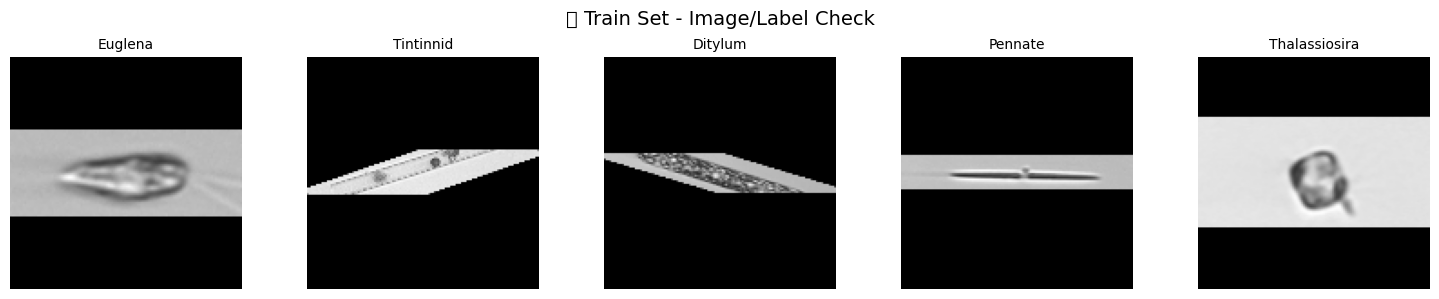

In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np

def debug_plot_images(X, y, label_encoder, title="Train Set", n=5):
    indices = random.sample(range(len(X)), n)
    plt.figure(figsize=(15, 3))

    for i, idx in enumerate(indices):
        image = X[idx].squeeze()
        label_index = np.argmax(y[idx])
        label = label_encoder.inverse_transform([label_index])[0]

        plt.subplot(1, n, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"{label}", fontsize=10)
        plt.axis("off")

    plt.suptitle(f"🔍 {title} - Image/Label Check", fontsize=14)
    plt.tight_layout()
    plt.show()

# ✅ Run it
debug_plot_images(X_train, y_train, label_encoder)


## **Load and Train the Model**<br>

**1-Load the pre-trained model**: Load the pre-trained (frozen) model and check the architecture.

**2-Modify the last layer of the model**: Remove the last layer of the pre-trained model (loaded_model) and replace it with a new output layer that fits your task (in this case, 22 classes)

**3-Unfreeze all layers**: Set all layers in the model to be trainable, allowing the weights to be updated during training.

**4-Recompile the model**: Recompile the model with a smaller learning rate (1e-4) to fine-tune the pre-trained model. The loss function used is categorical_crossentropy, and the metric is accuracy.

**5-Train the model**: Use the fit method to train the model for 100 epochs with a batch size of 32. Validation data (X_val, y_val) is provided to monitor performance during training. Early stopping and learning rate reduction callbacks are used to optimize training.

**6-Plot training history**: After training, visualize the model's accuracy and loss over the epochs for both the training and validation datasets. This helps in assessing the model's performance and convergence.

**Load the pre-trained model:**<br>
This step loads the pre-trained (frozen) model from the saved file and prints the model summary to check its architecture.

In [ ]:
#LOAD THE FROZEN MODEL
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np

# Load the entire model
loaded_model = load_model('/content/gdrive/MyDrive/practice_models/Frozen_model/frozen_model.h5')

# Print the summary of the loaded model to verify
loaded_model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_2 (InputLayer)                 │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 128, 128, 16)        │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 128, 128, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 42, 42, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 42, 42, 64)          │           9,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 42, 42, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 42, 42, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 42, 42, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 42, 42, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 42, 42, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 14, 14, 128)         │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 14, 14, 128)         │         147,5

 Total params: 2,923,415 (11.15 MB)

 Trainable params: 13,013 (50.83 KB)

 Non-trainable params: 2,910,400 (11.10 MB)

 Optimizer params: 2 (12.00 B)

**Modify the Last Layer of the Model:**<br>
The below cell removes the last layer of the pre-trained model (loaded_model) and replace it with a new output layer that fits your task (in this case, 22 classes). Then create a new model (new_model) and compile it using the Adam optimizer, categorical cross-entropy loss, and accuracy metric.

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

# Remove the last layer
x = loaded_model.layers[-2].output  # Get output before the last layer
new_output = Dense(22, activation='softmax', name='new_predictions')(x)  # Replace with 22 classes

# Create a new model
new_model = Model(inputs=loaded_model.input, outputs=new_output)

# Compile the model
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print new summary
new_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_2 (InputLayer)                 │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 128, 128, 16)        │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 128, 128, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 42, 42, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 42, 42, 64)          │           9,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 42, 42, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 42, 42, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 42, 42, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 42, 42, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 42, 42, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 14, 14, 128)         │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 14, 14, 128)         │         147,5

 Total params: 2,932,422 (11.19 MB)

 Trainable params: 22,022 (86.02 KB)

 Non-trainable params: 2,910,400 (11.10 MB)

**Unfreeze all Layers and Recompile the Model**<br>
The below cell unfreezes all layers of the model, making them trainable. The model is then recompiled with a smaller learning rate (1e-4) for fine-tuning. The loss function is set to categorical_crossentropy, and the metric is accuracy. A message confirms that all layers are now trainable and the model has been recompiled.

In [ ]:
# ✅ Unfreeze all layers
for layer in new_model.layers:
    layer.trainable = True

# ✅ Recompile model (must do this after changing trainable)
from tensorflow.keras.optimizers import Adam

new_model.compile(
    optimizer=Adam(learning_rate=1e-4),  # Smaller LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ All layers are now trainable and model recompiled.")


✅ All layers are now trainable and model recompiled.


**Train the Model**<br>
The below cell trains the model using the fit method, with X_train and y_train as the training data. The model is trained for 100 epochs with a batch size of 32. Validation data (X_val, y_val) is used to monitor performance during training. Two callbacks as defined in the first cell, early_stopping and reduce_lr, are used to optimize training by preventing overfitting and adjusting the learning rate as needed. The verbose=1 setting provides progress updates during training.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ✅ Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.001,
    verbose=1
)


In [ ]:
history = new_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 48s 46ms/step - accuracy: 0.2060 - loss: 2.8167 - val_accuracy: 0.0742 - val_loss: 3.7528 - learning_rate: 1.0000e-04
Epoch 2/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.6343 - loss: 1.1528 - val_accuracy: 0.6783 - val_loss: 1.2455 - learning_rate: 1.0000e-04
Epoch 3/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.7540 - loss: 0.7773 - val_accuracy: 0.7145 - val_loss: 1.1384 - learning_rate: 1.0000e-04
Epoch 4/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.8205 - loss: 0.5747 - val_accuracy: 0.7399 - val_loss: 1.0624 - learning_rate: 1.0000e-04
Epoch 5/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.8561 - loss: 0.4671 - val_accuracy: 0.7645 - val_loss: 0.9985 - learning_rate: 1.0000e-04
Epoch 6/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.8775 - loss: 0.3807 - val_accuracy: 0.7837 - val_loss: 1.0134 - learning_rate: 1.0000e-04
Epoch 7/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 21s 2

**Plot Training History**<br>
The below cell visualizes the training process by plotting both accuracy and loss over the epochs. Accuracy measures the proportion of correctly classified samples, providing insight into the model's predictive performance. Loss represents how far off the model's predictions are from the true labels, with lower loss indicating better performance. The first subplot displays the training and validation accuracy, while the second subplot shows the training and validation loss. These plots help assess whether the model is improving and if it’s overfitting or underfitting. The function is called after training to generate these plots.

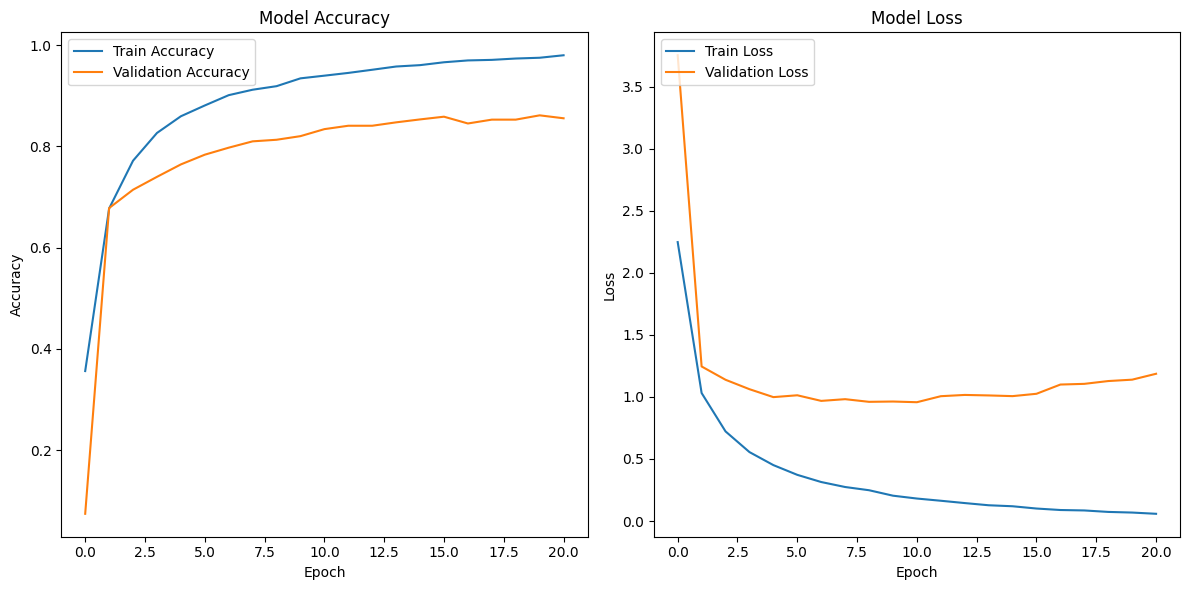

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # ✅ Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # ✅ Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# ✅ Call it after training
plot_training_history(history)


In [ ]:
# ✅ Save the EcoFOCI_V2 (BATCH) MODEL model as a single .h5 file
save_path = "/content/gdrive/MyDrive/practice_models/EcoFOCI_v2/EcoFOCI_v3_20epoch_model.h5"
new_model.save(save_path)

print(f"✅ Model saved to: {save_path}")


✅ Model saved to: /content/gdrive/MyDrive/practice_models/EcoFOCI_v2/EcoFOCI_v3_20epoch_model.h5


## **Evaluate the Model**<br>
**1-Evaluate accuracy and loss**: Calculates the test accuracy and test loss to assess model performance on the test data.

**2-Predict class probabilities**: Generates predicted class probabilities and converts them into class labels.

**3-Calculate the F1 score and generate a classification report**: Computes the F1 score and generates a detailed classification report for model evaluation.

**4-Plot confusion matrix**: Visualizes the model's predictions versus true labels using a confusion matrix.

**Evaluate accuracy and loss**:<br>
The below cell uses the evaluate method to assess the model's performance on the test dataset (x_test and y_test). It calculates the test accuracy (the proportion of correctly classified samples) and test loss (the error between predicted and actual labels). The results are printed to show how well the model generalizes to new, unseen data.

In [ ]:
# ✅ Evaluate accuracy and loss
test_loss, test_accuracy = new_model.evaluate(X_test, y_test, verbose=1)
print(f"✅ Test Accuracy: {test_accuracy:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8438 - loss: 0.8284
✅ Test Accuracy: 0.8450
✅ Test Loss: 0.8635


**Predict class probabilities**:<br>
The below cell is used to predict class probabilities on the test set with the predict method. These probabilities represent the model’s confidence in each class. The probabilities are then converted into class indices using np.argmax(), selecting the class with the highest probability. The true class labels are also converted into class indices for comparison. These probabilities are used in the subsequent steps to convert them into class labels and evaluate performance metrics.

In [ ]:
# ✅ Predict class probabilities
y_pred_probs = new_model.predict(X_test)

# ✅ Convert to class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step


**Calculate the F1 score and generate a classification report**:<br>
The F1 score is calculated using the f1_score function with the "macro" average, which gives equal importance to all classes, regardless of how often they appear. The F1 score is the harmonic mean of precision (how many selected items are correct) and recall (how many actual items were selected correctly). Using the harmonic mean ensures that both precision and recall are balanced, meaning that if one is very low, the F1 score will also be low. The classification report shows the precision, recall, and F1 score for each class, helping to evaluate how well the model performs across all categories.

In [ ]:
from sklearn.metrics import classification_report, f1_score

# ✅ F1 score (macro = equally weights all classes)
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')
print(f"✅ Macro F1 Score: {f1:.4f}")

# ✅ Full classification report
report = classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=label_encoder.classes_
)
print("📋 Classification Report:\n")
print(report)


✅ Macro F1 Score: 0.7705
📋 Classification Report:

                  precision    recall  f1-score   support

     Alexandrium       0.67      0.97      0.80        38
Asterionellopsis       0.39      1.00      0.56         9
     Chaetoceros       0.94      0.72      0.82       254
         Ciliate       0.95      0.95      0.95       158
      Coccoliths       0.44      0.73      0.55        49
       Corethron       0.71      0.95      0.81        94
   Coscinodiscus       0.60      0.92      0.73        26
     Cryptophyte       0.97      0.96      0.97       158
   Cylindrotheca       0.79      1.00      0.88        30
        Detritus       0.94      0.78      0.85       243
       Dictyocha       0.92      1.00      0.96        24
  Dinoflagellate       0.92      0.91      0.92       174
         Ditylum       0.79      0.97      0.87        32
       Elongated       0.84      0.89      0.86       235
         Euglena       0.97      0.99      0.98       150
  Nanoflagellate    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Plot confusion matrix**:<br>
A confusion matrix is generated using confusion_matrix from the sklearn.metrics module. The confusion matrix visualizes how well the model's predictions match the true labels by showing the counts of correct and incorrect predictions for each class. The matrix is displayed using a heatmap, making it easier to interpret the model's performance across different classes.

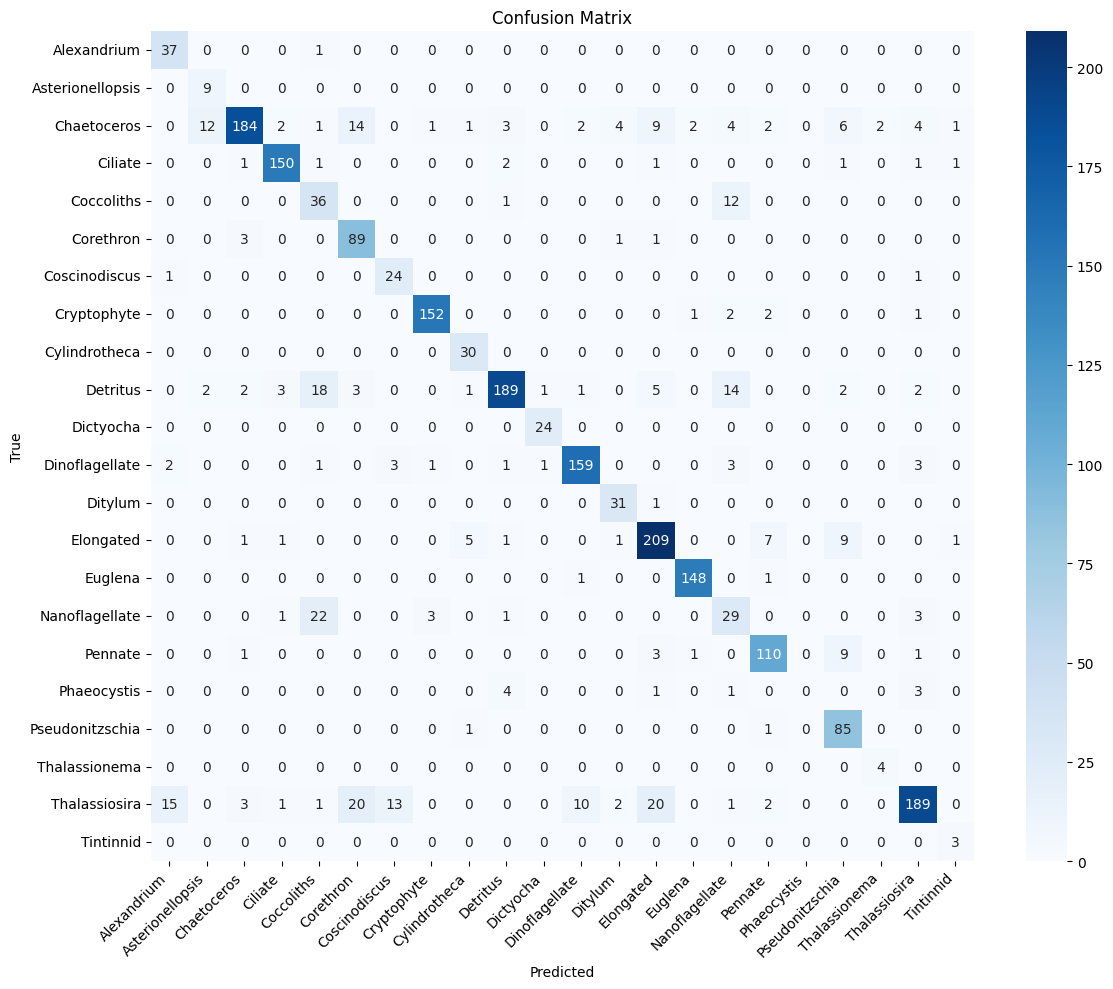

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# ✅ Create confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# ✅ Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**Additional**<br>
Below cell shows the summary and architecture of the model that we just trained.  


In [ ]:
#LOAD THE EcoFOCI_V2 (BATCH)MODEL
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np

# Load the entire model
loaded_model = load_model('/content/gdrive/MyDrive/practice_models/EcoFOCI_v2/EcoFOCI_v2_20epoch_model.h5')

# Print the summary of the loaded model to verify
loaded_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_2 (InputLayer)            │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 42, 42, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 42, 42, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 42, 42, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 42, 42, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 42, 42, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 42, 42, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 14, 14, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 14, 14, 64)     │        73,79

 Total params: 2,932,424 (11.19 MB)

 Trainable params: 2,929,190 (11.17 MB)

 Non-trainable params: 3,232 (12.62 KB)

 Optimizer params: 2 (12.00 B)